In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [30]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Figure out how to import regularizers
from tensorflow.keras import regularizers

import tensorflow as tf
import tensorflow.keras.utils as ku 
import numpy as np 

In [12]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1 
# 3211

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Input sequences 
# [[   0    0    0 ...    0   34  417]
#  [   0    0    0 ...   34  417  877]
#  [   0    0    0 ...  417  877  166]
#  ...
#  [   0    0    0 ...  493  493 3210]
#  [   0    0    0 ...  493 3210   15]
#  [   0    0    0 ... 3210   15   14]]

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

# predictors 
# [[   0    0    0 ...    0    0   34]
#  [   0    0    0 ...    0   34  417]
#  [   0    0    0 ...   34  417  877]
#  ...
#  [   0    0    0 ... 3209  493  493]
#  [   0    0    0 ...  493  493 3210]
#  [   0    0    0 ...  493 3210   15]]

# label
# [ 417  877  166 ... 3210   15   14]

label = ku.to_categorical(label, num_classes=total_words)
# One-hot label
# [[0. 0. 0. ... 0. 0. 0.]
#  [0. 0. 0. ... 0. 0. 0.]
#  [0. 0. 0. ... 0. 0. 0.]
#  ...
#  [0. 0. 0. ... 0. 0. 1.]
#  [0. 0. 0. ... 0. 0. 0.]
#  [0. 0. 0. ... 0. 0. 0.]]

--2020-07-12 08:18:55--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 173.194.69.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-07-12 08:18:55 (153 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [13]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(total_words*2, 'relu', kernel_regularizer=regularizers.l2()))
model.add(Dense(total_words, 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 200)           160800    
_________________________________________________________________
dropout (Dropout)            (None, 10, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                50200     
_________________________________________________________________
dense (Dense)                (None, 6422)              327522    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              20624253  
Total params: 21,483,875
Trainable params: 21,483,875
Non-trainable params: 0
____________________________________________

In [14]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 6s 12ms/step - loss: 6.8529 - accuracy: 0.0213
Epoch 2/100
484/484 [==============================] - 6s 12ms/step - loss: 6.5017 - accuracy: 0.0230
Epoch 3/100
484/484 [==============================] - 6s 13ms/step - loss: 6.3662 - accuracy: 0.0279
Epoch 4/100
484/484 [==============================] - 6s 12ms/step - loss: 6.2496 - accuracy: 0.0290
Epoch 5/100
484/484 [==============================] - 6s 12ms/step - loss: 6.1678 - accuracy: 0.0347
Epoch 6/100
484/484 [==============================] - 6s 12ms/step - loss: 6.0908 - accuracy: 0.0360
Epoch 7/100
484/484 [==============================] - 6s 12ms/step - loss: 6.0124 - accuracy: 0.0393
Epoch 8/100
484/484 [==============================] - 6s 12ms/step - loss: 5.9231 - accuracy: 0.0444
Epoch 9/100
484/484 [==============================] - 6s 12ms/step - loss: 5.8280 - accuracy: 0.0517
Epoch 10/100
484/484 [==============================] - 6s 12ms/step - loss: 5.720

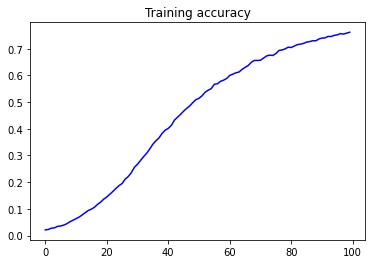

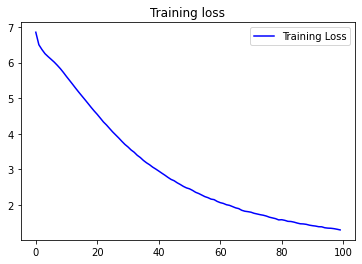

In [15]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [37]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict(token_list)
	predicted = tf.random.categorical(predicted, num_samples=1).numpy()
 
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope discourse power dress unfather'd whereupon limbecks blamed distill'd longing surfeit unprovident meetness bail governs imperfect action view bequest rightly favourites fore torments advance possesseth leese woman party report interchange vices poets race lock'd wires suppose gaudy decrepit inhabit came inheritors rhymers altering gazeth sheaves disarm'd frowns keen beyond worn wreckful alteration patent let drooping minion kills self themselves private deserves same patient commence freezings painter's gracious clouds flattery answers overthrow travell'd petty delights league honey sought weeks forgetfulness benefit swears desert confess cheer an victor celestial expired dust desiring longing longer sang strange almost pardon nimble aside spoils forsake nine
